<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Goals" data-toc-modified-id="Chapter-Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter Goals</a></span></li><li><span><a href="#Chapter-Outline" data-toc-modified-id="Chapter-Outline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Chapter Outline</a></span></li><li><span><a href="#Algo-Evaluation-Motivation" data-toc-modified-id="Algo-Evaluation-Motivation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Algo Evaluation Motivation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Algorithm-Uncertainty-(AU)" data-toc-modified-id="Algorithm-Uncertainty-(AU)-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Algorithm Uncertainty (AU)</a></span></li><li><span><a href="#Model-Uncertainty-(MU)" data-toc-modified-id="Model-Uncertainty-(MU)-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Model Uncertainty (MU)</a></span></li></ul></li></ul></li><li><span><a href="#1.-Read-in-backtest-portfolio-equity-data." data-toc-modified-id="1.-Read-in-backtest-portfolio-equity-data.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>1. Read in backtest <em>portfolio equity</em> data.</a></span></li><li><span><a href="#2.-Choose-the-Best-Algorithm-Among-4-Variants" data-toc-modified-id="2.-Choose-the-Best-Algorithm-Among-4-Variants-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>2. Choose the Best Algorithm Among 4 Variants</a></span></li><li><span><a href="#3.-Choose-Best-Bayesian-Model-of-Algorithm-Returns" data-toc-modified-id="3.-Choose-Best-Bayesian-Model-of-Algorithm-Returns-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>3. Choose Best Bayesian Model of Algorithm Returns</a></span><ul class="toc-item"><li><span><a href="#Model-Sampling-and-Comparison" data-toc-modified-id="Model-Sampling-and-Comparison-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Model Sampling and Comparison</a></span></li></ul></li><li><span><a href="#4.-Comparing-Bayesian-Cones-for-all-Algos-and-all-Return-Models" data-toc-modified-id="4.-Comparing-Bayesian-Cones-for-all-Algos-and-all-Return-Models-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>4. Comparing Bayesian Cones for all Algos and all Return Models</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Some-observations:" data-toc-modified-id="Some-observations:-7.0.1"><span class="toc-item-num">7.0.1&nbsp;&nbsp;</span>Some observations:</a></span></li></ul></li></ul></li><li><span><a href="#5.-Compare-Best-Algo's-Predicted-Portfolio-Ending-Values" data-toc-modified-id="5.-Compare-Best-Algo's-Predicted-Portfolio-Ending-Values-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>5. Compare Best Algo's Predicted Portfolio Ending Values</a></span></li><li><span><a href="#6.-Compare-Best-Algo-Predicted-CAGR-Distributions" data-toc-modified-id="6.-Compare-Best-Algo-Predicted-CAGR-Distributions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>6. Compare Best Algo Predicted CAGR Distributions</a></span></li><li><span><a href="#7.-Model-Averaging" data-toc-modified-id="7.-Model-Averaging-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>7. Model Averaging</a></span></li><li><span><a href="#8.-Conclusions" data-toc-modified-id="8.-Conclusions-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>8. Conclusions</a></span></li></ul></div>

## Chapter Goals

* Demonstrate how to extract algorithm portfolio equity from [Quantconnect](https://www.quantconnect.com/) backtest
* Demonstrate how to predict future return paths using [bayesian cones](https://blog.quantopian.com/bayesian-cone/).
* Demonstrate how to estimate distribution of algorithm CAGRs.
* Demonstrate how to use model averaging to aid predictions.

## Chapter Outline

1. Read in Algorithm Portfolio Equity
2. Choose the Best Algorithm Among 4 Variants
3. Choose Best Bayesian Model of Algorithm Returns
4. Compare Bayesian Cones for all Algos and all Return Models
5. Compare Best Algo Predicted Portfolio Ending Values
6. Compare Best Algo Predicted CAGR Distributions
7. Model Averaging
8. Conclusion

## Algo Evaluation Motivation

When evaluating our trading systems there are two major areas of uncertainty we have to address: `Algorithm Uncertainty`, `Model Uncertainty`. 

#### Algorithm Uncertainty (AU)
* trade sequencing
* slippage/price impact
* network errors
* software errors
* hardware errors

#### Model Uncertainty (MU)
* model is misspecified
* incorrect parameters
* changing market environment/nonstationarity
* missing variables
* etc.

What you will notice is that the `AU` examples given involve issues that can occur once our algorithm is live. What that also means is that some combination of those issues _did not happen_ in the past but some combination of them _could happen_ in the future. How can we estimate the impact of random exogenous shocks to our trading strategy's performance?

In this chapter we will employ a Bayesian methodology which will allow us to reasonably estimate the variation in strategy performance across many different return paths in an attempt to account for the exogenous shocks. The flip side to this approach is that we will have to use a model and all of the requisite assumptions. 

That introduces the second area of importance `MU`. To incorporate our uncertainty about which model is "best" we will create `3` different models and compare them. Then we will combine their predictions before we make our final inference and prediction.

*NOTE: in this chapter I have abstracted away some of the boilerplate code used to create and format data in the imported script `ch5_utils.py`. Some other functions and processes I have chosen to leave in the notebook for easier reference due to its importance in the analysis.*

In [10]:
%load_ext watermark
%watermark

# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'scripts' 
viz_dir = pdir / 'visuals' / '05_Algorithm_Evaluation'
log_dir = pdir / 'quantconnect_logs'
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 50)
import numpy as np
import sklearn.mixture as mix
import scipy.stats as stats
import math
import pymc3 as pm
from theano import shared, theano as tt
import ffn

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdvega

plt.style.use('seaborn-talk')
plt.style.use('bmh')

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from utils import cprint
from ch5_utils import pymc3_helper 
pmh = pymc3_helper()

RANDOM_STATE = 777

print()# 
%watermark -p pandas,pandas_datareader,numpy,pymc3,theano,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn,pdvega,pyarrow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-06-03T00:23:02-06:00

CPython 3.6.4
IPython 6.2.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.13.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit

pandas 0.23.0
pandas_datareader 0.6.0+21.gda18fbd
numpy 1.14.3
pymc3 3.4.1
theano 1.0.1
sklearn 0.19.1
statsmodels 0.9.0
scipy 1.1.0
ffn (0, 3, 3)
matplotlib 2.1.2
seaborn 0.8.1
pdvega 0.1
pyarrow 0.9.0


## 1. Read in backtest *portfolio equity* data.

To do this I have defined some useful convenience functions to clean up the raw dataset.

    1. Read in raw json 
    2. Extract portfolio equity from json, rename columns, and parse time column
    3. Rename df columns
    4. Read in the properly formatted df

In [23]:
def read_bt_json(fp):
    """fn: read Quantconnect backtest json"""
    with open(fp, encoding='utf-8') as f_in:
        return(json.load(f_in))
    
    
def extract_portfolio_equity(jdata):
    """fn: extract port equity timeseries from Quantconnect json"""
    d = jdata['Charts']['Strategy Equity']['Series']['Equity']['Values']
    equity = (pd.DataFrame(d)
              .rename(columns=dict(x='time', y='equity'))
              .assign(time=lambda df: pd.to_datetime(df.time, utc=True, unit='s'))
              .set_index('time'))
    return equity

def _get_column_name(text):
    """fn: to get column name as first text group"""
    n = 4 # hardcoded based on fn structure
    groups = text.split('_')
    return '_'.join(groups[:n])

def read_port_equity(fn):
    fp = PurePath(log_dir / fn)#.as_posix()
    jdata = read_bt_json(fp) 
    
    # get column name
    col = _get_column_name(fn)
    # extract equity data
    equity = (extract_portfolio_equity(jdata)
              .rename(columns=dict(equity=col)))
    return equity

In [24]:
#read_bt_json('/media/bcr/HDD/Code_Backups_Sync/mixture_model_trading/quantconnect_logs/normal_2_thres_70_cherry_picked.json')
norm_2_cp_equity = read_port_equity('normal_2_thres_70_cherry_picked.json')#  'normal_1_results.json')
norm_2_60_equity = read_port_equity('normal_2_thres_60.json')#_results.json')
norm_2_70_equity = read_port_equity('normal_2_thres_70.json')#_results.json')
norm_2_80_equity = read_port_equity('normal_2_thres_80.json')#_results.json')
cprint(norm_2_cp_equity)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           normal_2_thres_70
time                                        
2017-12-27 21:00:00+00:00        121831.3435
2017-12-28 14:31:00+00:00        121967.7462
2017-12-28 21:00:00+00:00        121905.5919
2017-12-29 14:31:00+00:00        122016.2468
2017-12-29 21:00:00+00:00        121930.2858
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4701 entries, 2008-09-01 04:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 1 columns):
normal_2_thres_70    4701 non-null float64
dtypes: float64(1)
memory usage: 73.5 KB
None
-------------------------------------------------------------------------------



Combine strategy dataframes into one df for easier analysis.

In [25]:
list_of_dfs = [norm_2_cp_equity, norm_2_60_equity, norm_2_70_equity, norm_2_80_equity]
dfs = (pd.concat(list_of_dfs, axis=1)
       .resample('D') 
       .mean() # resample to average daily value
       .dropna(how='all'))#.rename(columns={'normal_2_thres':'normal_2_thres_cp'}) 
cprint(dfs)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           normal_2_thres_70  normal_2_thres_60.json  \
time                                                                   
2017-12-22 00:00:00+00:00       121726.67730            110806.73870   
2017-12-26 00:00:00+00:00       121759.49840            110838.83710   
2017-12-27 00:00:00+00:00       121831.04605            110896.00425   
2017-12-28 00:00:00+00:00       121936.66905            110980.45065   
2017-12-29 00:00:00+00:00       121973.26630            111009.44045   

                           normal_2_thres_70.json  normal_2_thres_80.json  
time                                                                       
2017-12-22 00:00:00+00:00            120292.77430            109102.69330  
2017-12-26 00:00:00+00:00            120321.02100            109108.89120  
2017-12-2

In [26]:
# portfolio equity returns 
R = ffn.to_log_returns(dfs).dropna(how='all')
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           normal_2_thres_70  normal_2_thres_60.json  \
time                                                                   
2017-12-22 00:00:00+00:00           0.000000                0.001148   
2017-12-26 00:00:00+00:00           0.000270                0.000290   
2017-12-27 00:00:00+00:00           0.000587                0.000516   
2017-12-28 00:00:00+00:00           0.000867                0.000761   
2017-12-29 00:00:00+00:00           0.000300                0.000261   

                           normal_2_thres_70.json  normal_2_thres_80.json  
time                                                                       
2017-12-22 00:00:00+00:00                0.000000                0.000262  
2017-12-26 00:00:00+00:00                0.000235                0.000057  
2017-12-2

## 2. Choose the Best Algorithm Among 4 Variants

Now we can use a useful package called [ffn](https://github.com/pmorissette/ffn) to compute an assortment of performance statistics we can use to compare the algorithm portfolios. We're going to choose the best algorithm using the following metrics:

* Total Return
* Daily Sharpe
* CAGR
* Calmar Ratio

In [27]:
perf = ffn.calc_stats(dfs)

We can view the portfolio cumulative returns indexed to 100 easily

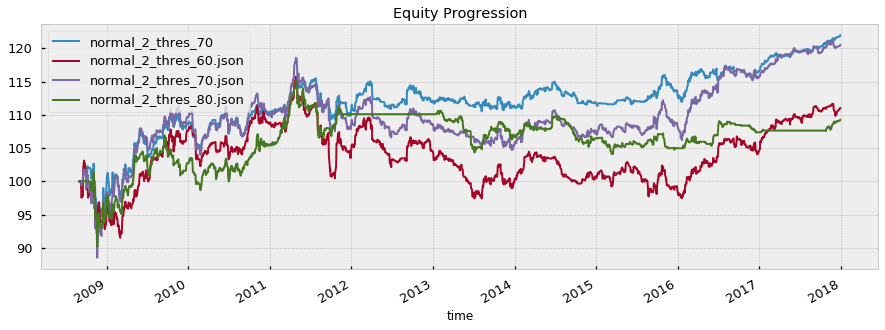

In [28]:
perf.plot()

Next we display the performance statistics.

In [29]:
perf.display()

Stat                 normal_2_thres_70    normal_2_thres_60.json    normal_2_thres_70.json    normal_2_thres_80.json
-------------------  -------------------  ------------------------  ------------------------  ------------------------
Start                2008-09-01           2008-09-01                2008-09-01                2008-09-01
End                  2017-12-29           2017-12-29                2017-12-29                2017-12-29
Risk-free rate       0.00%                0.00%                     0.00%                     0.00%

Total Return         21.97%               11.01%                    20.51%                    9.22%
Daily Sharpe         0.52                 0.24                      0.43                      0.24
Daily Sortino        0.58                 0.29                      0.48                      0.22
CAGR                 2.15%                1.13%                     2.02%                     0.95%
Max Drawdown         -9.67%               -15.83%      

Among the four algorithms, according to the four metrics listed above the clear "winner" is the `normal_4` algo variant. This refers to the algorithm version that uses `4` mixture components and predicts the return distribution by sampling from the `normal` distribution.

## 3. Choose Best Bayesian Model of Algorithm Returns


In this section we address the dual issues of **algorithm uncertainty** and **model uncertainty**.


### Model Sampling and Comparison

In this next section we model portfolio equity returns using 3 different distributions: `normal`, `laplace`, `student T`.
Then we compare the models.


$$ Y = \mu + \sigma $$

Here's the `Normal` specification:

$\mu \sim N(0,1)\\ \sigma \sim HalfCauchy(1)\\ Y \sim N(\mu, \sigma)$

Here's the `Laplace` specification:

$\mu \sim N(0,1)\\ \sigma \sim HalfCauchy(1)\\ Y \sim Laplace(\mu, \sigma)$

Here's the `Student T` specification:

$\nu \sim exp(.1)\\ \mu \sim N(0,1)\\ \sigma \sim HalfCauchy(1)\\ Y \sim StudentT(\nu+2, \mu, \sigma)$

In [30]:
%%time 
## Code adapted from: https://github.com/quantopian/pyfolio/blob/master/pyfolio/bayesian.py ##

def normal_model(R, samples):
    """fn: sample normal model of strategy returns
    
    # args 
        R: pd.Series() simple returns ts
        sample_wkds: dict containing sampler kwds
    # returns
        model, trace
    """
    with pm.Model() as model:
        mu = pm.Normal('mean rets', mu=0, sd=.01, testval=R.mean())
        sigma = pm.HalfCauchy('vol', beta=1, testval=R.std())
        returns = pm.Normal('returns', mu=mu, sd=sigma, observed=R)

        pm.Deterministic(
            'annual mean returns',
            returns.distribution.mean * 252)

        pm.Deterministic(
            'annual volatility',
            returns.distribution.variance**.5 *
            np.sqrt(252))

        pm.Deterministic(
            'sharpe',
            returns.distribution.mean /
            returns.distribution.variance**.5*np.sqrt(252))

        step = pm.NUTS()
        trace = pm.sample(samples, tune=samples, step=step) 
    return model, trace

def laplace_model(R, samples):
    """fn: sample laplace model of strategy returns
    
    # args 
        R: pd.Series() simple returns ts
        sample_wkds: dict containing sampler kwds
    # returns
        model, trace
    """
    with pm.Model() as model:
        mu = pm.Normal('mean rets', mu=0, sd=.01, testval=R.mean())
        sigma = pm.HalfCauchy('vol', beta=1, testval=R.std())
        returns = pm.Laplace('returns', mu=mu, b=sigma, observed=R)

        pm.Deterministic(
            'annual mean returns',
            returns.distribution.mean * 252)

        pm.Deterministic(
            'annual volatility',
            returns.distribution.variance**.5 *
            np.sqrt(252))

        pm.Deterministic(
            'sharpe',
            returns.distribution.mean /
            returns.distribution.variance**.5*np.sqrt(252))

        step = pm.NUTS(target_accept=.9)
        trace = pm.sample(samples, tune=samples, step=step) 
    return model, trace 

def student_model(R, samples):
    """fn: sample Student T model of strategy returns
    
    # args 
        R: pd.Series() simple returns ts
        sample_wkds: dict containing sampler kwds
    # returns
        model, trace
    """

    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1. / 10., testval=3.)
        mu = pm.Normal('mean rets', mu=0, sd=.01, testval=R.mean())
        sigma = pm.HalfCauchy('vol', beta=1, testval=R.std())
        returns = pm.StudentT('returns', nu=nu+2, mu=mu, sd=sigma, observed=R)

        pm.Deterministic(
            'annual mean rets',
            returns.distribution.mean * 252)

        pm.Deterministic(
            'annual volatility',
            returns.distribution.variance**.5*np.sqrt(252))

        pm.Deterministic(
            'sharpe',
            returns.distribution.mean /
            returns.distribution.variance**.5*np.sqrt(252))

        step = pm.NUTS(target_accept=.9)
        trace = pm.sample(samples, tune=samples, step=step) 
    return model, trace

def run_models_traces(r, samples=2_000):
    """fn: to run multiple models using algo returns
    
    # args
        r: shared theano array
            example: shared(R['normal_4'].values)
    # returns
        models: ordereddict with model outputs
        traces: ordereddict with trace outputs
    """

    # get model, traces
    norm_model, norm_trace = normal_model(r, samples)
    la_model, la_trace = laplace_model(r, samples)
    t_model, t_trace = student_model(r, samples)  
    
    # ordered dict is required to ensure insertion order
    # python 3.7 dict will implement insertion order feature by default
    models = od(norm_model=norm_model, la_model=la_model, t_model=t_model)    
    traces = od(norm_trace=norm_trace, la_trace=la_trace, t_trace=t_trace)
    return models, traces

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


For this portion of the analysis we will focus on the best algorithm variant `normal_4`.

In [33]:
%%time

best_algo_variant = 'normal_2_thres_70'
r = R[best_algo_variant].values
models, traces = run_models_traces(r)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vol_log__, mean rets]
  0%|          | 0/4000 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '29493' (I am process '29495')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/bcr/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '29493' (I am process '29496')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/bcr/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
100%|██████████| 4000/4000 [00:11<00:00, 337.14it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '29495' (I am process '29496')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/bcr/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
Multiprocess sampli

CPU times: user 6.2 s, sys: 705 ms, total: 6.91 s
Wall time: 1min 28s


In [39]:
traces[]

AttributeError: 'str' object has no attribute 'name'

In [34]:
LABEL_MAP = od(zip(range(len(models.keys())), models.keys()))

df_comp_WAIC = (pm.compare(traces.values(),
                           list(models.values()),
                           method='stacking')
                           #method='BB-pseudo-BMA') # using this method results in only 1 model being weighted
                .assign(model_code=lambda df: df.index))
df_comp = (df_comp_WAIC
           .assign(model_name=lambda df: (df.model_code
                                          .apply(lambda x: LABEL_MAP[x]))))
df_comp

AttributeError: 'MultiTrace' object has no attribute 'name'

In [ ]:
fig, ax = plt.subplots()
pm.compareplot(df_comp_WAIC, ax=ax);
ticks = ax.get_yticklabels()
new_ticklabels = pmh.make_new_ticklabels(LABEL_MAP, ticks)
ax.set_yticklabels(new_ticklabels);

In [ ]:
pm.forestplot(list(traces.values()))

The best model is the `t_model` as it has the smallest deviance critierion. We can look at its traceplots below.

In [ ]:
rvs = pmh.get_model_varnames(models['t_model'])
pmh.plot_traces_pymc(traces['t_trace'], varnames=rvs)

## 4. Comparing Bayesian Cones for all Algos and all Return Models

Even though we already know which model best describes the data, let's compare these algo variants and models a little more, in order to better understand how the model choices affect our algorithm performance predictions.

To demonstrate this, in the next section we will sample from each of the 3 models for each of the 4 algorithm variants and output their predicted performance in the form of a [bayesian cone](https://blog.quantopian.com/bayesian-cone/). I first became aware of this concept via Thomas Wiecki at Quantopian. Simply put it is a Bayesian methodology to predict the probable return paths of the algorithm in question. Their primary use case was trying to determine if an algorithm was overfitted to its sample period by comparing its performance since going **live** vs its **backtest** performance. Once an algorithm is **live** if it severely underperforms the sampled bayesian credible intervals then it is likely overfitted.

However in this use case we are going to adapt the methodology to simply predict the algo's likely return paths (aka future performance) and our uncertainty concerning the predicted performance.

First we are going to make a prediction dictionary to hold the following information for each model:

* `name`: this is the string name of the model and the dictionary key.
* `ppc_samples`: this is the raw `pm.sample_ppc()` output.
* `ppc`: this is a formatted df of the `ppc_samples` output.
* `cuml_df`: this is a formatted df of *predicted* cumulative returns.

In [ ]:
%%time

preds = {}

for algo_name in R.columns:
    print('-'*77)
    print(f'sampling algorithm variant: {algo_name}')
    print()
    tmp_dict = {}
    tmp_r = shared(R[algo_name].dropna().values)
    tmp_models, tmp_traces = run_models_traces(tmp_r)
    
    for (name, model), trace in zip(tmp_models.items(), tmp_traces.values()):
        ppc_samples = pm.sample_ppc(trace, 
                                    samples=252*2,
                                    model=model,
                                    size=tmp_r.eval().shape[0])
        ppc, cuml_df = pmh.make_df(ppc_samples)
        tmp_dict[name] = dict(ppc_samples=ppc_samples,
                              ppc=ppc,
                              cuml_df=cuml_df)
    preds[algo_name] = tmp_dict

In this section we are adapting the [bayesian cone](https://github.com/quantopian/pyfolio/blob/master/pyfolio/bayesian.py) code from [pyfolio](https://github.com/quantopian/pyfolio) for our use case below. 

1. The first function `make_train_test()` is creating the train and test splits needed for the bayesian cone plot. In the original use case this is a little simpler because we would simply be splitting the algorithm return series at the date when the algorithm is **live**. In this custom implementation we are using *all* of the algorithm's *cumulative returns + 1*, as the **train** set. The **test** set is the *predicted mean* of the sampled cumulative returns scaled by the last return of the train set.

2. The function `compute_bayes_cone()` is calculating the percentile scores, or returns at the specified percentiles.

3. The function `plot_bayes_cone()` plots a single algorithm's predicted performance along with credible intervals we computed `compute_bayes_cone()`

4. The function `plot_bayes_cone_grid()` is simply a wrapper function to plot each of the `4` algorithm variants with each of the `3` models for easy comparison

In [ ]:
## Code adapted from: https://github.com/quantopian/pyfolio/blob/master/pyfolio/bayesian.py ##

def make_train_test(returns, cuml_df):
    """fn: to make train test dfs
    
    # args
        returns: pd.Series()
        cuml_df: df of simulated cuml returns
    
    # returns
        train, test: pd.Series(), pd.DataFrame()
    """
    t = returns.cumsum().add(1)
    t_test = cuml_df['mean_sim_port'].add(1) * t.iloc[-1]
    t_test.index = t_test.index.tz_localize('utc')
    return t, t_test

def compute_bayes_cone(preds, starting_value=1.):
    """
    Compute 5, 25, 75 and 95 percentiles of cumulative returns, used
    for the Bayesian cone.
    Parameters
    ----------
    preds : numpy.array
        Multiple (simulated) cumulative returns.
    starting_value : int (optional)
        Have cumulative returns start around this value.
        Default = 1.
    Returns
    -------
    dict of percentiles over time
        Dictionary mapping percentiles (5, 25, 75, 95) to a
        timeseries.
    """

    def scoreatpercentile(cum_preds, p):
        return [stats.scoreatpercentile(
            c, p) for c in cum_preds.T]

    cum_preds = np.cumprod(preds + 1, 1) * starting_value
    perc = {p: scoreatpercentile(cum_preds, p) for p in (5, 25, 75, 95)}

    return perc

def plot_bayes_cone(train, test, algo_name, model_name, percentiles, ax=None):
    """fn: plot bayes cone using train 'test' split"""
    if ax is None: ax = plt.gca()
        
    t = train
    t_rel = test
    t.loc[t_rel.index[0]] = t_rel.iloc[0]

    t.plot(ax=ax, color='g', label='in-sample')
    t_rel.plot(ax=ax, color='r', label='future estimate')

    ax.fill_between(t_rel.index, percentiles[5], percentiles[95], alpha=.3)
    ax.fill_between(t_rel.index, percentiles[25], percentiles[75], alpha=.6)
    ax.legend(loc='upper left', frameon=True, framealpha=0.5)
    ax.set_title(f'Bayesian cone || {algo_name}::{model_name}')
    ax.set_xlabel('')
    ax.set_ylabel('Cumulative returns')

    ax.set_xlim(t.index[0], t_rel.index[-1])


def plot_bayes_cone_grid(preds, R, LABEL_MAP):

    algo_names = R.columns
    model_names = list(LABEL_MAP.values())
    
    n = len(model_names)
    m = len(algo_names)
    
    fig, axes = plt.subplots(m,n, figsize=(15,15))

    for i, algo_name in enumerate(algo_names):    
        for j, model_name in enumerate(model_names):

            r = R[algo_name]
            tmp_c_df = preds[algo_name][model_name]['cuml_df']
            train, test = make_train_test(r, tmp_c_df)

            tmp_ppc_samples = preds[algo_name][model_name]['ppc_samples']
            
            # extract subsample before computing cone
            df_t = (pd.DataFrame(tmp_ppc_samples['returns'])
                    .sample(len(tmp_ppc_samples['returns']),
                            axis=1)
                    .values)
            perc = compute_bayes_cone(df_t, starting_value=train.iloc[-1])

            ax = axes[i,j]
            plot_bayes_cone(train, test, algo_name, model_name, perc, ax=ax)
        plt.suptitle('Bayesian cone || algo_name::model_name', fontsize=14, fontweight='medium',)
    plt.tight_layout()    
    fig.subplots_adjust(top=.9)
    save_pth = PurePath(viz_dir/f'bayesian_cones_comparison.png').as_posix()
    fig.savefig(save_pth, dpi=300, bbox_inches='tight')    

Now let's examine the results.

In [ ]:
## plot
plot_bayes_cone_grid(preds, R, LABEL_MAP)

#### Some observations:

* If we look at the first column which features all 4 algo variants paired with the `norm_model` we can see that compared to the other columns the `norm_model` consistently has the widest dispersion of predicted return paths. This is somewhat counterintuitive given that the Student T model is supposed to incorporate wider tails. 

* Looking at the `la_model` column we can see that it consistently estimates the predicted return path to hover very close to zero on average no matter what the performance of the of the algorithm was. To me this would signify that the `la_model` is misspecified or that the `laplace` likelihood we used to model the returns is too restrictive. The `la_model` also seems to have the smallest range in the cone compared to the others.

* The `t_model` seems to incorporate a good blend of the uncertainty in our predictions and the previous algorithm performance. It seems to be somewhere in the middle in terms of the width of the cone, between the `norm_model` and the `la_model`. 
    * We can see some potential misspecification with the `normal_1` algo paired with the `t_model`. The bayesian cone appears artificially tight around the predicted values.
    * Also we can see some sampling errors in the with `laplace` algo paired `t_model`. For whatever reason there is no cone produced at all. 


## 5. Compare Best Algo's Predicted Portfolio Ending Values
## 6. Compare Best Algo Predicted CAGR Distributions

In the next section we will quantify our observations about the bayesian cone widths. We will again disregard all the other algorithm variants and use our `best_algo_variant` which is the `normal_4` algo to compare each of the `3` models and the width's of their bayesian cones at the **end** of the prediction period. To do this we will be using the distribution of the simulated portfolio ending values and comparing their `5, 50, 95` percentile values. 

This analysis will also allow us to compare estimated CAGRs of the `best_algo_variant` for each of the `3` return models.

First let's look at a quick sample of the predicted cumulative return paths of our best algorithm with the "best" model of returns.

In [ ]:
%%time

ex_cuml_df = preds[best_algo_variant]['t_model']['cuml_df']

fig, ax = plt.subplots(figsize=(15,5))
ex_cuml_df.sample(150, axis=1).plot(legend=False, ax=ax, x_compat=True)
xmin, xmax = ex_cuml_df.index.min(), ex_cuml_df.index.max()
ax.set_xlim((xmin, xmax))
save_pth=PurePath(viz_dir/f'best_algo_t_model_simulated_paths_sample.png').as_posix()
fig.savefig(save_pth, dpi=300)

In this section we are going to extract the simulated portfolio ending values using the best algo variant `normal_4` and for each return model and we're going to compare the ending value distributions.

We will also compute **CAGR's** for each simulated return path and summarize the distribution of expected CAGRs using the `5, 50, 95` percentiles. 

In [ ]:
n_cols = 5000
quantiles = [0.05,.5,.95]
model_names = list(LABEL_MAP.values())

for model in model_names:
    ## get ppc, paths and end vals 
    tmp_ppc = preds[best_algo_variant][model]['ppc']
    sim_path_df = pmh.get_paths(tmp_ppc, n_cols)
    sim_end_val = pmh.get_end_vals(sim_path_df)
    
    ## plot sim port end vals
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    pmh.plot_port_end_dist(sim_end_val, axes,
                           model_name=model)
    save_pth = PurePath(viz_dir/f'best_algo_{model}_simulated_ending_values_dist.png').as_posix()
    fig.savefig(save_pth, dpi=300)
    ## plot cagr bar
    cagr = ffn.calc_cagr(sim_path_df)
    step = .01
    pcts = np.arange(0,1+step,step)
    pcts = np.round(pd.Index(pcts),2)
    ser = cagr.quantile(pcts)    

    fig, ax = plt.subplots(figsize=(15,3))
    pmh.plot_cagr_bar(ser, quantiles,
                      ax, model_name=model)
    save_pth = PurePath(viz_dir/f'best_algo_{model}_simulated_cagr_perc.png').as_posix()
    fig.savefig(save_pth, dpi=300)    

## 7. Model Averaging

So now we have `3` return models. Our previous `WAIC` based decision criterion told us that the `t_model` does the best job of modeling the algorithm returns. But as we can see there are other potentially credible models that hold information that could help improve our predictions. How can we incorporate other useful models in our predictions?

Lucky for us `pymc3` has made the process straightforward. In section `3` we compared our `3` models using `pm.compare()`. The output dataframe has a column of `weights` which we can *"vaguely interpret as the probability that each model will make the correct predictions on future data."*

Next we can use the function `pm.sample_ppc_w()` to incorporate those weights. Make sure the weights are ordered identically to the traces and models we constructed above.

In [ ]:
traces.keys()

In [ ]:
models.keys()

In [ ]:
od_weights = df_comp.set_index('model_name').weight[::-1]
od_weights, od_weights.index

In [ ]:
def make_ppc_w(traces, models, weights, samples=500):
    """fn: sample wtd ppc
    
    # args
        traces: list of traces
        models: list of models
        weights: pd.Series of weights
    
    # return
        ppc_dfs: df of wtd ppc samples
    """
    ppc_w_dfs = []
    for _ in tqdm(range(samples)):
        ppc_w = pm.sample_ppc_w(traces, 252*2, models,
                                weights=weights, progressbar=False)
        ppc_df = pmh.make_ppc_df(ppc_w).T.drop_duplicates(keep='last').T
        ppc_w_dfs.append(ppc_df)

    ppc_dfs = pd.concat(ppc_w_dfs, axis=1)
    ppc_dfs.columns = [str(x) for x in range(samples)]
    ppc_dfs = pmh.make_mean_path(ppc_dfs)
    return ppc_dfs

In [ ]:
%%time
ts = list(traces.values())
ms = list(models.values())

ppc_dfs = make_ppc_w(ts, ms, od_weights)
cprint(ppc_dfs)

In [ ]:
n_cols = 1000
quantiles = [0.05,.5,.95]

## get ppc, paths and end vals 
sim_path_df = pmh.get_paths(ppc_dfs, n_cols)
sim_end_val = pmh.get_end_vals(sim_path_df)

## plot sim port end vals
fig, axes = plt.subplots(1,2, figsize=(15,3))
pmh.plot_port_end_dist(sim_end_val, axes,
                       model_name='stacked_model')
save_pth = PurePath(viz_dir/f'stacked_model_simulated_ending_values_dist.png').as_posix()
fig.savefig(save_pth, dpi=300)

## plot cagr bar
cagr = ffn.calc_cagr(sim_path_df)
step = .01
pcts = np.arange(0,1+step,step)
pcts = np.round(pd.Index(pcts),2)
ser = cagr.quantile(pcts)    

fig, ax = plt.subplots(figsize=(15,3))
pmh.plot_cagr_bar(ser, quantiles,
                  ax, model_name='stacked_model')
save_pth = PurePath(viz_dir/f'stacked_model_simulated_cagr_perc.png').as_posix()
fig.savefig(save_pth, dpi=300)  

What if we try our own arbitrary weights?

In [ ]:
%%time

new_weights = [0.3, 0.1, 0.6]

new_ppc_dfs = make_ppc_w(ts, ms, new_weights)
cprint(new_ppc_dfs)

In [ ]:
n_cols = 1000
quantiles = [0.05,.5,.95]

## get ppc, paths and end vals 
sim_path_df = pmh.get_paths(new_ppc_dfs, n_cols)
sim_end_val = pmh.get_end_vals(sim_path_df)

## plot sim port end vals
fig, axes = plt.subplots(1,2, figsize=(15,3))
pmh.plot_port_end_dist(sim_end_val, axes,
                       model_name='alt_stacked_model')
save_pth = PurePath(viz_dir/f'alt_stacked_model_simulated_ending_values_dist.png').as_posix()
fig.savefig(save_pth, dpi=300)

## plot cagr bar
cagr = ffn.calc_cagr(sim_path_df)
step = .01
pcts = np.arange(0,1+step,step)
pcts = np.round(pd.Index(pcts),2)
ser = cagr.quantile(pcts)    

fig, ax = plt.subplots(figsize=(15,3))
pmh.plot_cagr_bar(ser, quantiles,
                  ax, model_name='alt_stacked_model')
save_pth = PurePath(viz_dir/f'alt_stacked_model_simulated_cagr_perc.png').as_posix()
fig.savefig(save_pth, dpi=300)  

## 8. Conclusions

Using our `stacked_model` with the original pymc3 generated weights we can interpret the results as so; Trading the `Normal_4` algorithm variant, we would expect over the next `252*2` days that our portfolio equity will be between `~$96K` and `~$106K` with an expected value of `~$101K`. The predicted CAGR is estimated to be between `-2.6%` and `+4.0%` with an expected value of `0.7%`. 